In [2]:
from music21 import converter, instrument, note, chord,midi,stream
import numpy as np
from collections import Counter
import operator
from read_data_fft import get_data,get_stft,write_data,normalize,unormalize,inverse_stft,get_chunks,display_stft
import sys
sys.path.append( '../')
import utils
import tensorflow as tf
import os
import glob
from librosa.core import magphase

In [5]:
tf.reset_default_graph()

learning_rate = 1e-3

BATCH_SIZE = 3
epochs=1

# length of the sequence generated
TIMESTEPS=50

x_train=get_data('chopin_8000.wav',100000)
max_=np.max(x_train)
min_=np.min(x_train)

x_train-=min_
x_train/=max_


x_train=get_stft(x_train).T

angle=np.expand_dims(np.angle(x_train),axis=-1)
x_train=np.expand_dims(x_train,axis=-1)
x_train=np.concatenate((x_train,angle),axis=-1)



x_train=get_chunks(x_train,chunk_size=100)
#x_train=np.expand_dims(x_train,axis=-1)
print x_train.shape

X_G = tf.placeholder("float", [None, x_train.shape[1],x_train.shape[2],x_train.shape[3]])
X_real = tf.placeholder("float", [None, x_train.shape[1],x_train.shape[2],x_train.shape[3]])

def noise(size):
    return np.random.randn(size,x_train.shape[1],x_train.shape[2],x_train.shape[3])

def generator(X): 
    with tf.variable_scope('generator',reuse=False):
        x = tf.layers.conv2d_transpose(inputs=X, filters=32, kernel_size=(3,3), padding='same', activation=tf.nn.tanh)
        x = tf.layers.conv2d_transpose(inputs=x, filters=32, kernel_size=(3,3), padding='same', activation=tf.nn.tanh)
        x = tf.layers.conv2d_transpose(inputs=x, filters=32, kernel_size=(3,3), padding='same', activation=tf.nn.tanh)
        x = tf.layers.conv2d_transpose(inputs=x, filters=2, kernel_size=(3,3), padding='same')
        return x

def discriminator(x,reuse=False):
    with tf.variable_scope('discriminator',reuse=reuse):
        x = tf.layers.conv2d(inputs=x, filters=32, kernel_size=(3,3), padding='same',activation=tf.nn.tanh)
        x = tf.layers.max_pooling2d(x, pool_size=(2,2), strides=(2,2), padding='same')
        x = tf.layers.conv2d(inputs=x, filters=32, kernel_size=(3,3), padding='same',activation=tf.nn.tanh)
        x = tf.layers.max_pooling2d(x, pool_size=(2,2), strides=(2,2), padding='same')
        x = tf.layers.conv2d(inputs=x, filters=32, kernel_size=(3,3), padding='same',activation=tf.nn.tanh)
        x = tf.layers.max_pooling2d(x, pool_size=(2,2), strides=(2,2), padding='same')
        x = tf.layers.conv2d(inputs=x, filters=32, kernel_size=(3,3), padding='same',activation=tf.nn.tanh)
        x = tf.layers.max_pooling2d(x, pool_size=(2,2), strides=(2,2), padding='same')
        x=tf.layers.dense(x,128,activation=tf.nn.tanh)
        x=tf.layers.dense(x,1)
        return x


#generate a sequence when giving some random noise
output_g=generator(X_G)

# should tell it's a fake sequence because we are giving the ouput of the generator
output_d_fake=discriminator(output_g)

# should tell it's a true sequence because we are giving a true sequence
output_d_real=discriminator(X_real,reuse=True)

T_vars = tf.trainable_variables()

#list to train only the generator layers
var_list_G = [var for var in T_vars if var.name.startswith('generator')]

#list to train only the discriminator layers
var_list_D = [var for var in T_vars if var.name.startswith('discriminator')]


#the diagonale in the the confusion matrix
#compute the error of missclassified image (it says it's false instead of true) 
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=output_d_real, labels=tf.ones_like(output_d_real)))
#compute the error of missclassified image (it says it's true instead of false) 
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=output_d_fake, labels=tf.zeros_like(output_d_fake)))

#discriminator's error
loss1 = D_loss_real + D_loss_fake

#generator's error
loss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=output_d_fake, labels=tf.ones_like(output_d_fake)))

# we train both discrimantor and generator
optimizer1 = tf.train.AdamOptimizer(learning_rate).minimize(loss1,var_list=var_list_D)
optimizer2 = tf.train.AdamOptimizer(learning_rate).minimize(loss2,var_list=var_list_G)


sess=tf.Session()
sess.run(tf.global_variables_initializer())
val_loss_list = []   
for epoch in range(0,epochs):
#     we train the discriminator
    for batch_i in range(0, x_train.shape[0], BATCH_SIZE):
        _,loss_1 = sess.run([optimizer1,loss1], feed_dict={
            X_G: noise(x_train[batch_i:batch_i + BATCH_SIZE].shape[0]), X_real: x_train[batch_i:batch_i + BATCH_SIZE]})
    # we train the generator
    for batch_i in range(0, x_train.shape[0], BATCH_SIZE):
        _,loss_2 = sess.run([optimizer2,loss2], feed_dict={X_G: noise(BATCH_SIZE)})
    print('Discriminator loss :',loss_1,'Generator loss :',loss_2)

(4, 100, 1025, 2)
('Discriminator loss :', 1.2578503, 'Generator loss :', 0.42403966)


(100, 1025, 2)


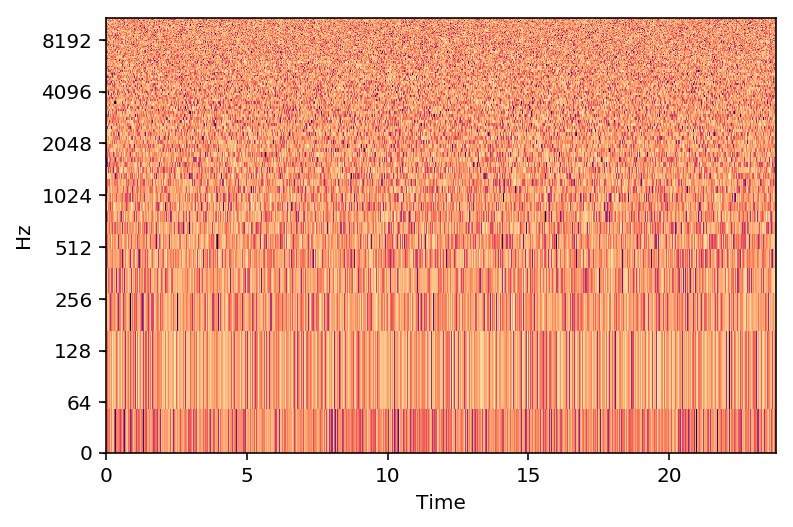

(100, 1025)


In [6]:
#generate noise for the generator in order to generate a sequence
z_sample=np.random.rand(1,x_train.shape[1],x_train.shape[2],x_train.shape[3])
#generate the sequence with the nn above
a=sess.run(output_g,feed_dict={X_G:z_sample})
#get the result
music_generated=a[0]
#unormalize
# music_generated*=std
# music_generated+=mean
print music_generated.shape
display_stft(music_generated[:,:,0])

music_generated=music_generated[:,:,0]*np.exp(1j*music_generated[:,:,1])
print music_generated.shape
signal=inverse_stft(music_generated.T)

write_data(signal,'test.wav')